# Introduction
The best Pittsburgh neighborhood has the most economic opportunities and infrastructure. We based it on these principles because the neighborhood with the most opportunity is more likely to grow, thrive, and achieve long-term success. Neighborhoods with more inactive business licenses or vacant government property suggest a stagnant population and will reflect negatively on their ranking. Other datasets, like metrics on individual business types, were considered, but did not capture the whole story of each neighborhood. The datasets we analyzed are as follows.
Assets
City-owned properties
Businesses

# City Owned Properties
For our City-owned properties metric, we first counted the total number of city-owned properties in each neighborhood. We then created a burden scale, which is simply the amount of vacant properties divided by the total number of properties in each neighborhood. We made sure to exclude neighborhoods that had fewer than 25 city-owned properties, as they would stand as an outlier and would not apply to our goal.

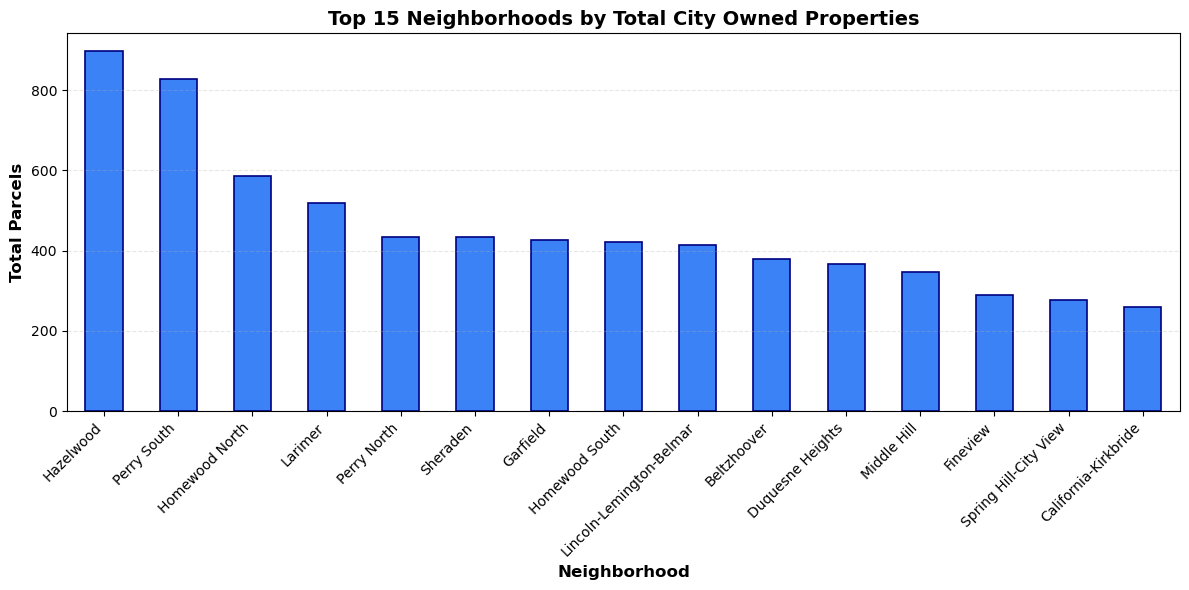

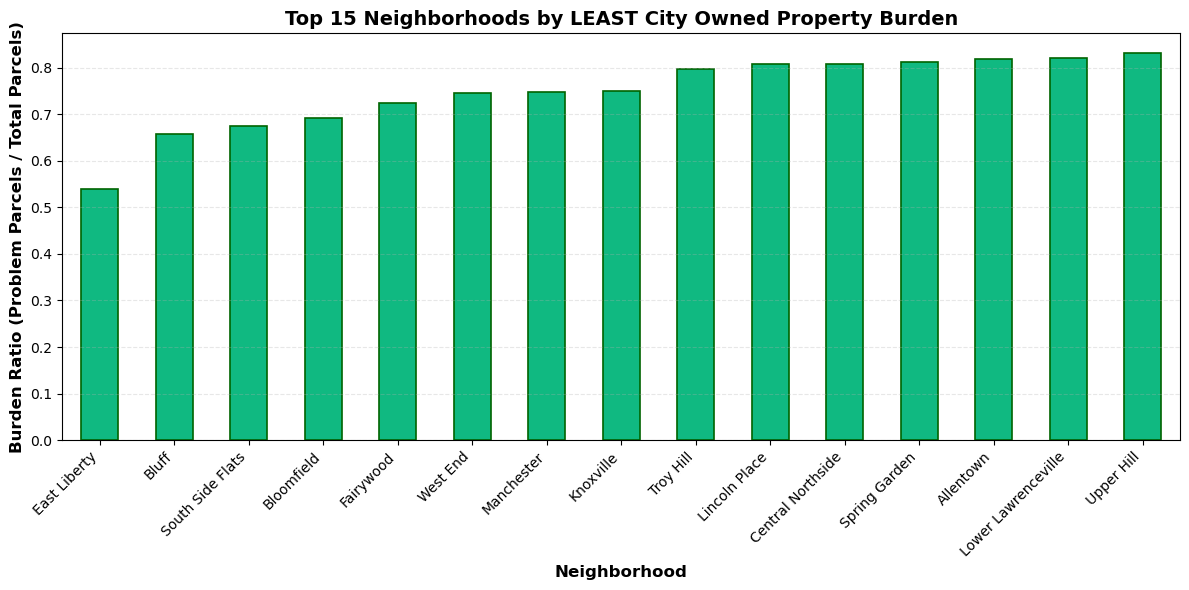


Dataset Summary:
  • Total neighborhoods (≥25 properties): 68
  • Total city-owned parcels: 12,438
  • Total problem parcels: 11,331
  • Overall burden ratio: 91.10%

COMPLETE NEIGHBORHOOD RANKINGS
Rank   Neighborhood                        Total      Problem    Non-Prob   Burden %     Rank by Burden 
------------------------------------------------------------------------------------------------------------------------
1      Hazelwood                           897        811        86         90.4       % #29            
2      Perry South                         828        779        49         94.1       % #47            
3      Homewood North                      586        532        54         90.8       % #31            
4      Larimer                             520        482        38         92.7       % #39            
5      Perry North                         433        420        13         97.0       % #60            
6      Sheraden                            433    

AttributeError: 'dict' object has no attribute 'head'

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the city-owned properties data
city = pd.read_csv("https://data.wprdc.org/datastore/dump/e1dcee82-9179-4306-8167-5891915b62a7?bom=True", low_memory=False)

# Find neighborhood column
neighborhood_col = None
for col in city.columns:
    if 'neighborhood' in col.lower() or 'hood' in col.lower():
        neighborhood_col = col
        break

if neighborhood_col is None:
    print("Available columns:", city.columns.tolist())
    print("\nPlease specify the neighborhood column name")
else:
    # Drop rows without neighborhood
    city = city.dropna(subset=[neighborhood_col])
    
    # Find columns for problem identification
    inventory_col = None
    status_col = None
    
    for col in city.columns:
        col_lower = col.lower()
        if 'inventory' in col_lower or 'type' in col_lower:
            inventory_col = col
        if 'status' in col_lower or 'current' in col_lower:
            status_col = col
    
    # Create problem mask based on "class" column check if it's Vacant Land or Building
    if 'class' in city.columns:
        problem_mask = city['class'].astype(str).str.contains("Vacant Land|Vacant Building", case=False, na=False)
    else:
        # Fallback to other columns if 'class' doesn't exist
        problem_mask = pd.Series([False] * len(city), index=city.index)
        
        if inventory_col:
            problem_mask |= city[inventory_col].astype(str).str.contains("Vacant|Surplus|Sideyard|Reserve", case=False, na=False)
        
        if status_col:
            problem_mask |= city[status_col].astype(str).str.contains("Vacant|Demolition|Abandoned", case=False, na=False)
    
    city["is_problem"] = problem_mask
    
    # Group by neighborhood
    city_grouped = city.groupby(neighborhood_col).agg(
        total_parcels=('class', 'count'),
        problem_parcels=('is_problem', 'sum')
    )
    
    # Calculate metrics
    city_grouped['burden_ratio'] = city_grouped['problem_parcels'] / city_grouped['total_parcels']
    city_grouped['non_problem_parcels'] = city_grouped['total_parcels'] - city_grouped['problem_parcels']
    city_grouped['burden_percentage'] = city_grouped['burden_ratio'] * 100
    
    # Filter for neighborhoods with at least 25 parcels
    city_grouped_filtered = city_grouped[city_grouped['total_parcels'] >= 25].copy()
    
    # Sort by total parcels
    city_grouped_sorted = city_grouped_filtered.sort_values('total_parcels', ascending=False)
    
    # Sort by burden ratio (ascending for least burden)
    burden_sorted = city_grouped_filtered.sort_values('burden_ratio', ascending=True)
    
    # Top 15 Neighborhoods by Total City Owned Properties
    plt.figure(figsize=(12, 6))
    city_grouped_sorted.head(15)['total_parcels'].plot(kind='bar', color='#3b82f6', edgecolor='navy', linewidth=1.2)
    plt.title('Top 15 Neighborhoods by Total City Owned Properties', fontsize=14, fontweight='bold')
    plt.xlabel('Neighborhood', fontsize=12, fontweight='bold')
    plt.ylabel('Total Parcels', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Top 15 Neighborhoods by LEAST City Owned Property Burden
    plt.figure(figsize=(12, 6))
    burden_sorted.head(15)['burden_ratio'].plot(kind='bar', color='#10b981', edgecolor='darkgreen', linewidth=1.2)
    plt.title('Top 15 Neighborhoods by LEAST City Owned Property Burden', fontsize=14, fontweight='bold')
    plt.xlabel('Neighborhood', fontsize=12, fontweight='bold')
    plt.ylabel('Burden Ratio (Problem Parcels / Total Parcels)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # DATA TABLE
    print("="*120)
    print(f"\nDataset Summary:")
    print(f"  • Total neighborhoods (≥25 properties): {len(city_grouped_filtered)}")
    print(f"  • Total city-owned parcels: {city_grouped_filtered['total_parcels'].sum():,}")
    print(f"  • Total problem parcels: {int(city_grouped_filtered['problem_parcels'].sum()):,}")
    print(f"  • Overall burden ratio: {city_grouped_filtered['problem_parcels'].sum() / city_grouped_filtered['total_parcels'].sum():.2%}")
    
    print("\n" + "="*120)
    print("COMPLETE NEIGHBORHOOD RANKINGS")
    print("="*120)
    print(f"{'Rank':<6} {'Neighborhood':<35} {'Total':<10} {'Problem':<10} {'Non-Prob':<10} {'Burden %':<12} {'Rank by Burden':<15}")
    print("-"*120)
    
    # Create ranking columns
    city_grouped_sorted['rank_total'] = range(1, len(city_grouped_sorted) + 1)
    city_grouped_sorted['rank_burden'] = city_grouped_sorted['burden_ratio'].rank(ascending=True, method='min').astype(int)
    
    for idx, row in city_grouped_sorted.iterrows():
        print(f"{int(row['rank_total']):<6} {idx:<35} {int(row['total_parcels']):<10} {int(row['problem_parcels']):<10} {int(row['non_problem_parcels']):<10} {row['burden_percentage']:<11.1f}% #{int(row['rank_burden']):<14}")
    
    print("="*120)

    # Create a Python object (dictionary) for each neighborhood
city_objects = []

burden_series = city_grouped_filtered["burden_ratio"]

# Sort ascending (least burden first)
burden_sorted = burden_series.sort_values(ascending=True).head(15)

# Assign weights
neighborhood_weights = {}
for i, (n, ratio) in enumerate(burden_sorted.items()):
    w = 15 - i
    neighborhood_weights[n] = {
        "burden_weight": w,
        "asset_weight": 0,
        "business_weight": 0,
    }


 # Given this data, we can conclude that East Liberty has the smallest percentage of city burden.


# Assets
For assets we wanted to determine which assets were inside each of the Pittsburgh neighborhoods, things like parks, libraries, community centers, public facilities,etc. For this dataset I had to map each asset to a neighborhood using zip codes and the city’s census tract. How I did this was extract the 5 digit zip code then mapped it to a census tract and then mapped it to a neighborhood using the properties dataset(had zip code and neighborhood name). 

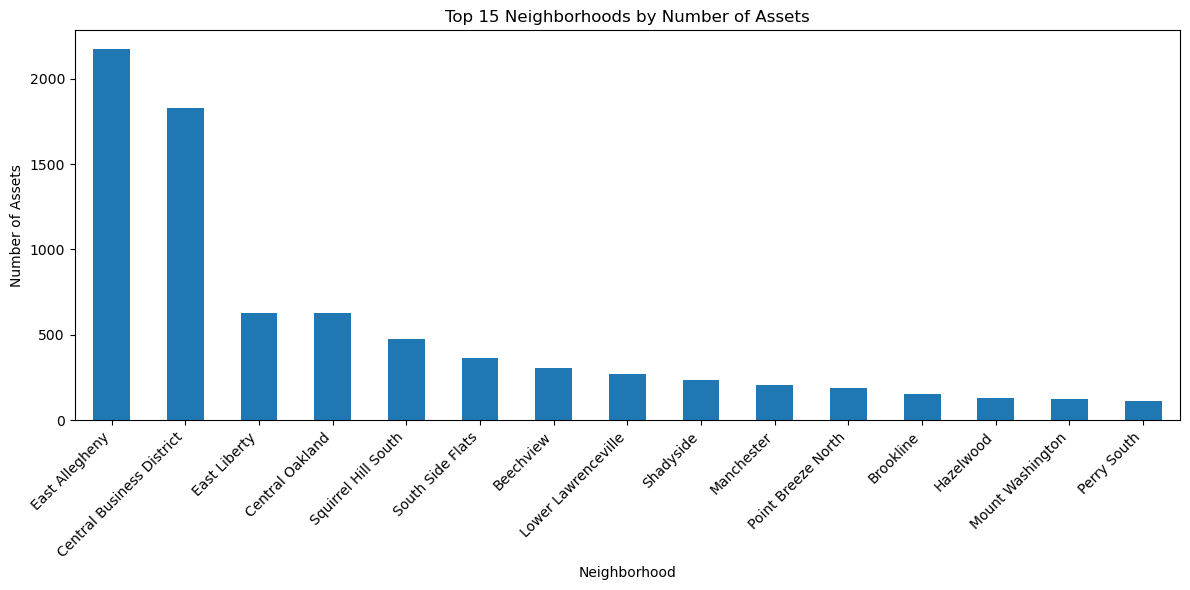

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
assets = pd.read_csv("Assets.csv", low_memory=False)
city = pd.read_csv("CityOwnedProperties.csv", low_memory=False)
zip_tract = pd.read_csv("ZIP_TRACT_032020.csv", low_memory=False)
#drop rows without zip codes
#Extract 5 digit code
#Set zip to a int
assets_zip = assets.dropna(subset=["zip_code"]).copy()
assets_zip["zip5"] = assets_zip["zip_code"].astype(str).str.extract(r"(\d{5})")[0]
assets_zip = assets_zip.dropna(subset=["zip5"])
assets_zip["zip_int"] = assets_zip["zip5"].astype(int)

#ensure no missing values
zip_tract = zip_tract.dropna(subset=["ZIP", "TRACT"]).copy()
zip_tract["ZIP_int"] = zip_tract["ZIP"].astype(int)
zip_tract["TRACT_int"] = zip_tract["TRACT"].astype("int64")
#pick census tract by % of adresses in the tract
zip_primary = (
    zip_tract.sort_values("TOT_RATIO", ascending=False)
             .drop_duplicates("ZIP_int")[["ZIP_int", "TRACT_int"]]
)
#remove missing neighborhoods
#convert tract to integer
city_tt = city.dropna(subset=["census_tract", "neighborhood_name"]).copy()
city_tt["census_tract_int"] = city_tt["census_tract"].astype("int64")
#find the most common neighborhood in each tract
tract_to_hood = (
    city_tt.groupby("census_tract_int")["neighborhood_name"]
           .agg(lambda s: s.value_counts().idxmax())
           .reset_index()
)
#Map zip code to neighborhood
zip_to_hood = zip_primary.merge(
    tract_to_hood,
    left_on="TRACT_int",
    right_on="census_tract_int",
    how="inner"
)
#attach each neighborhood to an asset
assets_with_hood = assets_zip.merge(
    zip_to_hood[["ZIP_int", "neighborhood_name"]],
    left_on="zip_int",
    right_on="ZIP_int",
    how="left"
)
#count assets per neighborhood
assets_per_neighborhood = (
    assets_with_hood
    .dropna(subset=["neighborhood_name"])
    .groupby("neighborhood_name")["asset_id"]
    .count()
    .sort_values(ascending=False)
)

assets_sorted = assets_per_neighborhood.sort_values(ascending=False).head(15)

for i, (n, count) in enumerate(assets_sorted.items()):
    w = 15 - i
    if n not in neighborhood_weights:
        neighborhood_weights[n] = {
            "burden_weight": 0,
            "asset_weight": 0,
            "business_weight": 0,
        }
    neighborhood_weights[n]["asset_weight"] = w
#plot
top_n = 15
plt.figure(figsize=(12, 6))
assets_per_neighborhood.head(top_n).plot(kind="bar")
plt.title(f"Top {top_n} Neighborhoods by Number of Assets")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Assets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# The winner of this metric was east Allegheny. This makes sense because they have a high concentration of schools, libraries and parks.

# Businesses

For businesses, we wanted to look at the total number of business licenses registered in each neighborhood. The business licenses can help get a sense of the job market within each neighborhood, with neighborhoods containing more licenses having presumably more job opportunities. We determined neighborhoods based on the provided zip codes registered to each business.


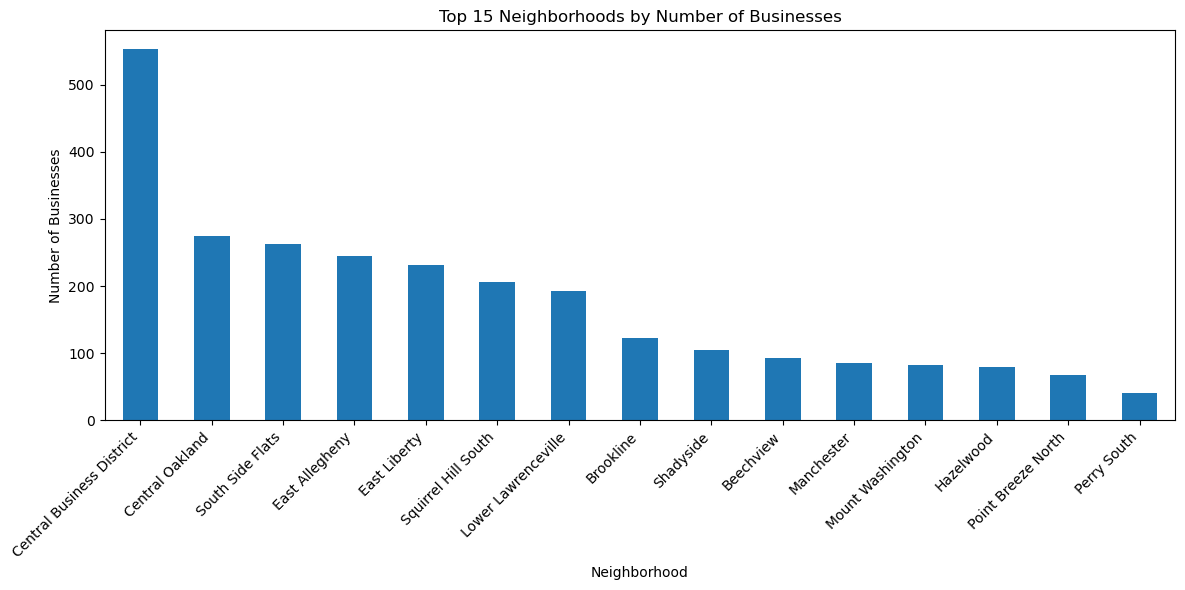

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

business = pd.read_csv("Buisness's.csv", low_memory=False)
city = pd.read_csv("CityOwnedProperties.csv", low_memory=False)
zip_tract = pd.read_csv("ZIP_TRACT_032020.csv", low_memory=False)
#Get zip code from buisness adress
business["zip5"] = business["address"].astype(str).str.extract(r"(\d{5})")
business = business.dropna(subset=["zip5"])
business["zip_int"] = business["zip5"].astype(int)
#prepare for merging 
zip_tract = zip_tract.dropna(subset=["ZIP", "TRACT"]).copy()
zip_tract["ZIP_int"] = zip_tract["ZIP"].astype(int)
zip_tract["TRACT_int"] = zip_tract["TRACT"].astype("int64")
# maps tract to zip code 
zip_primary = (
    zip_tract.sort_values("TOT_RATIO", ascending=False)
             .drop_duplicates("ZIP_int")[["ZIP_int", "TRACT_int"]]
)
#prepare city data
city_ct = city.dropna(subset=["census_tract", "neighborhood_name"]).copy()
city_ct["census_tract_int"] = city_ct["census_tract"].astype("int64")
#map tract to neighborhood assigned to which neighborhood appears most in each tract
tract_to_hood = (
    city_ct.groupby("census_tract_int")["neighborhood_name"]
           .agg(lambda s: s.value_counts().idxmax())
           .reset_index()
)
#map zip code and neighborhood
zip_to_hood = zip_primary.merge(
    tract_to_hood,
    left_on="TRACT_int",
    right_on="census_tract_int",
    how="inner"
)
#attach neighborhood to buinesses
business_with_hood = business.merge(
    zip_to_hood[["ZIP_int", "neighborhood_name"]],
    left_on="zip_int",
    right_on="ZIP_int",
    how="left"
)
#count buinesses in each neighborhood
business_counts = (
    business_with_hood
    .dropna(subset=["neighborhood_name"])
    .groupby("neighborhood_name")["business_name"]
    .nunique()
    .sort_values(ascending=False)
)
business_sorted = business_counts.sort_values(ascending=False).head(15)

for i, (n, count) in enumerate(business_sorted.items()):
    w = 15 - i
    if n not in neighborhood_weights:
        neighborhood_weights[n] = {
            "burden_weight": 0,
            "asset_weight": 0,
            "business_weight": 0,
        }
    neighborhood_weights[n]["business_weight"] = w

#plot
plt.figure(figsize=(12, 6))
business_counts.head(15).plot(kind="bar")
plt.title("Top 15 Neighborhoods by Number of Businesses")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Based on this data, we can infer that the central business district has the highest number of job opportunities.



# Total 

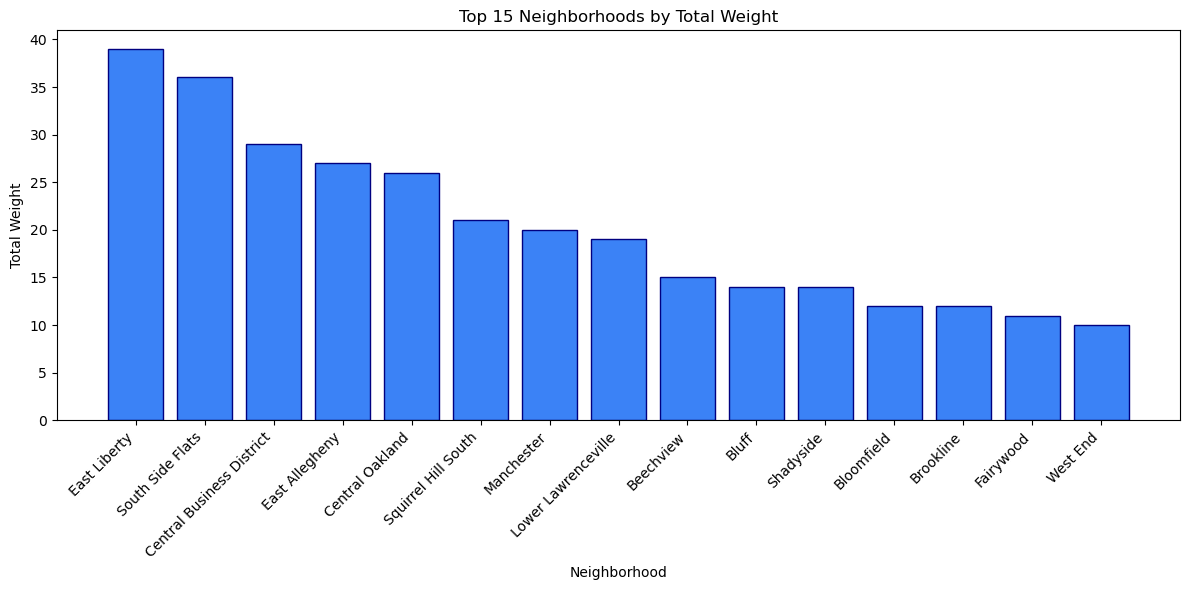

In [31]:
for n in neighborhood_weights:
    neighborhood_weights[n]["total_weight"] = (
        neighborhood_weights[n]["burden_weight"] +
        neighborhood_weights[n]["asset_weight"] +
        neighborhood_weights[n]["business_weight"]
    )
final_sorted = sorted(
    neighborhood_weights.items(),
    key=lambda x: x[1]["total_weight"],
    reverse=True
)

top_15 = final_sorted[:15]

plt.figure(figsize=(12, 6))
plt.bar(names, totals, color="#3b82f6", edgecolor="navy")
plt.title("Top 15 Neighborhoods by Total Weight")
plt.xlabel("Neighborhood")
plt.ylabel("Total Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Dylan
My personal favorite neighborhood is South Side. I really enjoy the restaurants and atmosphere in South Side, it's very lively and there are a lot of cool events in the street I like to go to. The abundance of businesses and old-school vibe add to its vibe. Also, the food there is very good on south side my personal favorite is Cafe de Jour. 

# Gyan
My favorite part of town is shadyside, I like this because of kind of the small town vibe of it in a city. Shadyside has a lot of cool stores down there, I personally really like to go down to shadyside to thrift, also the cafes down in shadyside are also good my personal favorite is cafe moulin.

# Conclusion
Overall, we concluded East Liberty to be the best neighborhood. This is because it was top 5 in assets and total number of businesses, even though it didn't hold a high number of city-owned properties, we believe it outweighs this. This makes sense because of the redevelopment of this town. They also host various businesses, one that sticks out is the Google office down there. Check out the Target or Whole Foods in East Liberty, and if you're looking for a  quick and cheap bite, walk down to Slice on Broadway and grab a slice, or two!